In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
from cmcrameri import cm
from datetime import datetime
import babet as bb

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
inidates = ['2023-10-11', '2023-10-15', '2023-10-17']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
# Import forecast data data
curr_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/EU025/pl/pf'
curr = xr.open_mfdataset(os.path.join(curr_dir, '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

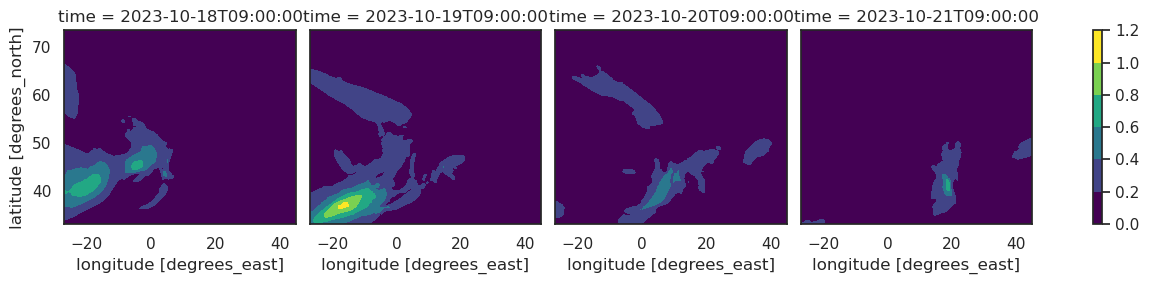

In [4]:
# Calculate integrated water vapour transport (IVT)
bb.Met.calc_ivt(curr.q, curr.u, curr.v).mean('number').sel(time=['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09'], inidate='2023-10-15').plot.contourf(col='time')